In [2]:
'''This module is used to create the education report for the designated year'''

'This module is used to create the education report for the designated year'

# Yearly Report of Colleges

In [106]:
# importing dependencies
import pandas as pd
import psycopg
import matplotlib.pyplot as plt
from credentials import DB_NAME, DB_USER, DB_PASSWORD
import sys
import seaborn



In [141]:
# connecting to SQL
conn = psycopg.connect(
        host="pinniped.postgres.database.azure.com", dbname= DB_NAME,
        user= DB_USER, password= DB_PASSWORD
    )

In [142]:
YEAR = 2022
#YEAR = sys.argv[1]

## Loan Repayment Rate over Time

/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/971763065.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  defaults = pd.read_sql_query('''SELECT AVG(cdr3), year_data FROM finances


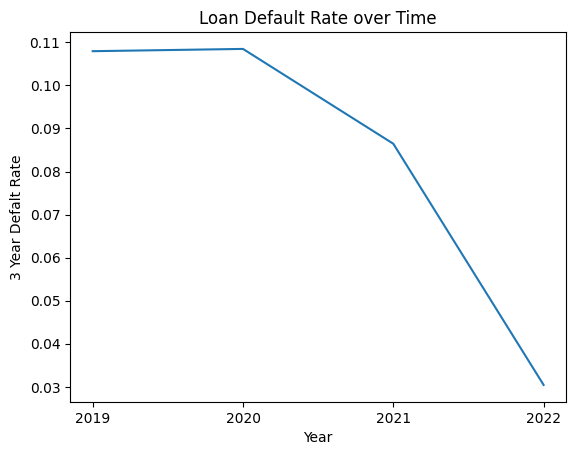

In [109]:
defaults = pd.read_sql_query('''SELECT AVG(cdr3), year_data FROM finances
                  WHERE year_data <= %(YEAR)s 
                  GROUP BY year_data
                  ORDER BY year_data
                  ''', conn, params={'YEAR':YEAR})

plt.plot(defaults.year_data.astype(int), defaults.avg)
plt.title('Loan Default Rate over Time')
plt.xlabel('Year')
plt.ylabel('3 Year Defalt Rate')
plt.xticks(list(defaults.year_data))
plt.show()

/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/4018683756.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  defaults_type = pd.read_sql_query('''SELECT finances.year_data, control.control, AVG(cdr3)


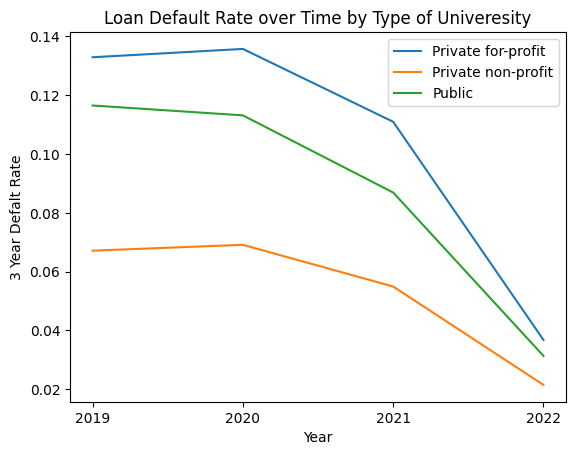

In [111]:
defaults_type = pd.read_sql_query('''SELECT finances.year_data, control.control, AVG(cdr3)
                                   FROM finances
                    LEFT JOIN fast_facts ON finances.unitid = fast_facts.unitid
                                  AND finances.year_data = fast_facts.year_data
                    LEFT JOIN control ON fast_facts.control = control.code
                  WHERE finances.year_data <= %(YEAR)s 
                  GROUP BY finances.year_data, control.control
                  ORDER BY finances.year_data
                  ''', conn, params={'YEAR':YEAR})
defaults_wide =  defaults_type.pivot(index='year_data', columns='control', values='avg').reset_index()



plt.plot(defaults_wide.year_data.astype(int), defaults_wide["Private for-profit"])
plt.plot(defaults_wide.year_data.astype(int), defaults_wide["Private non-profit"])
plt.plot(defaults_wide.year_data.astype(int), defaults_wide["Public"])
plt.title('Loan Default Rate over Time by Type of Univeresity')
plt.xlabel('Year')
plt.ylabel('3 Year Defalt Rate')
plt.xticks(list(defaults.year_data))
plt.legend(defaults_wide.columns[1:4])
plt.show()

## Tuition by Type of University

/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/681939558.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  in_tuitions = pd.read_sql_query('''SELECT tuitionfee_in, control.control


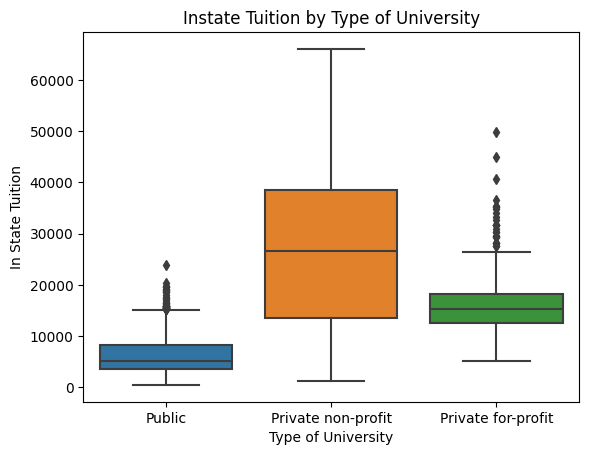

In [125]:
in_tuitions = pd.read_sql_query('''SELECT tuitionfee_in, control.control
                  FROM finances
                  LEFT JOIN fast_facts ON finances.unitid = fast_facts.unitid
                                  AND finances.year_data = fast_facts.year_data
                    LEFT JOIN control ON fast_facts.control = control.code
                  WHERE finances.year_data = %(YEAR)s
                  ''', conn, params={'YEAR':YEAR})

seaborn.boxplot(x= in_tuitions.control, y=in_tuitions.tuitionfee_in)
plt.title('Instate Tuition by Type of University')
plt.xlabel("Type of University")
plt.ylabel("In State Tuition")
plt.show()

/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/2394827409.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  out_tuitions = pd.read_sql_query('''SELECT tuitionfee_out, control.control


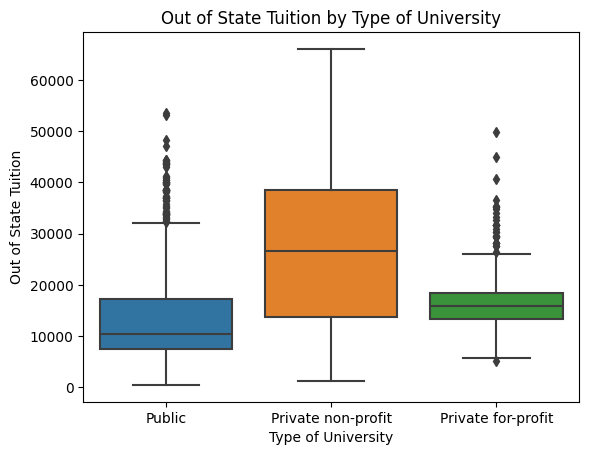

In [123]:
out_tuitions = pd.read_sql_query('''SELECT tuitionfee_out, control.control
                  FROM finances
                  LEFT JOIN fast_facts ON finances.unitid = fast_facts.unitid
                                  AND finances.year_data = fast_facts.year_data
                    LEFT JOIN control ON fast_facts.control = control.code
                  WHERE finances.year_data = %(YEAR)s
                  ''', conn, params={'YEAR':YEAR})

seaborn.boxplot(x= out_tuitions.control, y=out_tuitions.tuitionfee_out)
plt.title('Out of State Tuition by Type of University')
plt.xlabel("Type of University")
plt.ylabel("Out of State Tuition")
plt.show()

## In State Tuition by 3 Year Default Rate 

/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/4131476779.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tuition_loans=pd.read_sql_query('''SELECT TUITIONFEE_IN, CDR3


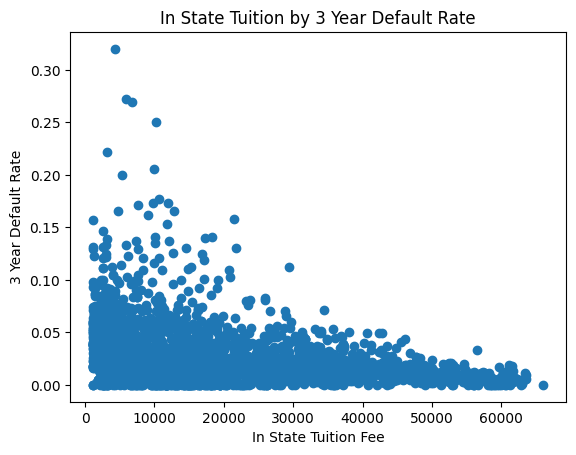

In [150]:
tuition_loans=pd.read_sql_query('''SELECT TUITIONFEE_IN, CDR3
                  FROM finances
                  WHERE year_data = %(YEAR)s
                  ''', conn, params={'YEAR':YEAR})

plt.scatter(tuition_loans.tuitionfee_in, tuition_loans.cdr3)
plt.title('In State Tuition by 3 Year Default Rate')
plt.xlabel("In State Tuition Fee")
plt.ylabel("3 Year Default Rate")
plt.show()

In [149]:
tuition = pd.read_sql_query('''SELECT STABBR,  AVG(tuitionfee_in)
                             AS in_state,
                             AVG(tuitionfee_out) AS out_state
                  FROM finances
                  INNER JOIN location ON finances.unitid = location.unitid
                  WHERE finances.year_data = %(YEAR)s
                  GROUP BY STABBR
                  ORDER BY in_state DESC, out_state DESC
                  ''', conn, params = {'YEAR':YEAR})
tuition.rename(columns={'stabbr': 'State Abbreviation', 'in_state':'Average In State Tuition',
                        'out_state':'Average Out of State Tuition'}, inplace = True)
tuition.style.hide_index()


/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/429165557.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tuition = pd.read_sql_query('''SELECT STABBR,  AVG(tuitionfee_in)
/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/429165557.py:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  tuition.style.hide_index()


State Abbreviation,Average In State Tuition,Average Out of State Tuition
VT,34063.461538,39915.769231
RI,33061.230769,36253.538462
MA,31886.096774,34473.924731
DC,28958.083333,29529.083333
PA,25954.333333,27706.913793
IN,23326.084746,26892.237288
IA,22647.745098,23973.549020
CT,22620.951220,29361.439024
NH,21692.727273,26952.272727
NY,20804.769231,22747.457875


In [144]:
control_df = pd.read_sql_query('''SELECT STABBR, control.control, COUNT(fast_facts.control) FROM
                  fast_facts
                  INNER JOIN location ON fast_facts.unitid = location.unitid
                  LEFT JOIN control ON fast_facts.control = control.code
                  WHERE year_data = %(YEAR)s
                  GROUP BY control.control, STABBR
                  ORDER BY STABBR, control.control
                  ''',conn, params = {'YEAR': YEAR})
control_df.rename(columns = {'control': 'Control of Institution',
                     'stabbr': 'State Abbreviation',
                     'count': 'Number of Instituions'}, inplace = True)
control_df.style.hide_index()


/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/1166930460.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  control_df = pd.read_sql_query('''SELECT STABBR, control.control, COUNT(fast_facts.control) FROM
/var/folders/q_/scw1z2kj1ps9t_rf_gf8gg6c0000gn/T/ipykernel_50567/1166930460.py:12: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  control_df.style.hide_index()


State Abbreviation,Control of Institution,Number of Instituions
AK,Private for-profit,1
AK,Private non-profit,3
AK,Public,5
AL,Private for-profit,19
AL,Private non-profit,19
AL,Public,38
AR,Private for-profit,30
AR,Private non-profit,17
AR,Public,35
AS,Public,1
